In [14]:
from IPython.display import display
import numpy as np
import openml
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

def get_openmldata(datset_id):

    dataset = openml.datasets.get_dataset(dataset_id)
    X, y, categorical_indicator, attribute_names = dataset.get_data(
        dataset_format="dataframe", target=dataset.default_target_attribute
    )
    print(f"Data has {X.shape[0]} rows and {X.shape[1]} columns.")
    display(X.head())
    display(y.head())

    for col in X.columns[categorical_indicator]:
        X[col] = X.loc[:,col].astype("category")
        X[col] = X.loc[:,col].cat.codes.astype("int32")
    
    return X, y, categorical_indicator

class TabularDataset(torch.utils.data.Dataset):
    def __init__(self, X, y, categorical_features, continuous_features):
        super(TabularDataset, self).__init__()
        self.categorical_features = categorical_features
        self.continuous_features = continuous_features
        self.X_categorical = torch.tensor(X[categorical_features].values, dtype=torch.long)
        self.X_continuous = torch.tensor(X[continuous_features].values, dtype=torch.float32)
        self.y = torch.tensor(y.values, dtype=torch.float32)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return (self.X_categorical[idx], self.X_continuous[idx], self.y[idx])

# Zurich delays dataset: https://www.openml.org/search?type=data&sort=runs&id=45045&status=active
# dataset_id = 45045

# Diamonds dataset: https://www.openml.org/search?type=data&sort=runs&id=44059&status=active
dataset_id = 44059

X, y, categorical_indicator = get_openmldata(dataset_id)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = .3)
X_valid, X_test, y_valid, y_test = train_test_split(X_valid, y_valid, test_size = .7)
n = X.shape[0]
n_train = X_train.shape[0]
n_valid = X_valid.shape[0]
n_test = X_test.shape[0]

print(f"Training on {n_train:,} ({n_train/n:.1%})\nValidation on {n_valid:,} ({n_valid/n:.1%})\nTest on {X_test.shape[0]:,} ({n_test/n:.1%})")

categorical_features = X.columns[np.array(categorical_indicator)]
continuous_features = X.columns[~np.array(categorical_indicator)]

train_dataset =  TabularDataset(X_train, y_train, categorical_features, continuous_features)
valid_dataset =  TabularDataset(X_valid, y_valid, categorical_features, continuous_features)

train_dataloader = DataLoader(train_dataset, batch_size = 200, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size = 200, shuffle=True)

Data has 53940 rows and 9 columns.


,carat,cut,color,clarity,depth,table,x,y,z
0,0.23,2,1,3,61.5,55.0,3.95,3.98,2.43
1,0.21,3,1,2,59.8,61.0,3.89,3.84,2.31
2,0.23,1,1,4,56.9,65.0,4.05,4.07,2.31
3,0.29,3,5,5,62.4,58.0,4.20,4.23,2.63
4,0.31,1,6,3,63.3,58.0,4.34,4.35,2.75


0    5.789960
1    5.789960
2    5.793014
3    5.814131
4    5.817111
Name: price, dtype: float64

Training on 37,758 (70.0%)
Validation on 4,854 (9.0%)
Test on 11,328 (21.0%)


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class TabularTransformer(nn.Module):
    def __init__(self, num_continuous_features, num_categories, num_category_embeddings, embedding_dim, num_heads, hidden_dim, dropout_prob):
        super(TabularTransformer, self).__init__()

        # Embedding layers for categorical features
        self.category_embeddings = nn.ModuleList([nn.Embedding(num_categories[i], embedding_dim) for i in range(num_category_embeddings)])
        self.total_embedding_dim = embedding_dim * num_category_embeddings

        # Linear layers for continuous features
        self.continuous_layer = nn.Linear(num_continuous_features, embedding_dim)
        self.total_embedding_dim += embedding_dim

        # Transformer layers
        self.transformer_encoder_layer = nn.TransformerEncoderLayer(d_model=self.total_embedding_dim, nhead=num_heads, dim_feedforward=hidden_dim, dropout=dropout_prob)
        self.transformer_encoder = nn.TransformerEncoder(self.transformer_encoder_layer, num_layers=2)

        # Output layer
        self.output_layer = nn.Linear(self.total_embedding_dim, 1)

    def forward(self, x_categorical, x_continuous):
        # Embed categorical features
        categorical_embeddings = [self.category_embeddings[i](x_categorical[:, i]) for i in range(x_categorical.shape[1])]
        categorical_embeddings = torch.cat(categorical_embeddings, dim=1)

        # Embed continuous features
        continuous_embedding = F.relu(self.continuous_layer(x_continuous))

        # Concatenate embeddings
        x = torch.cat([categorical_embeddings, continuous_embedding], dim=1)

        # Pass through transformer
        x = self.transformer_encoder(x)

        # Pass through output layer
        x = self.output_layer(x)

        return x.squeeze()

In [16]:
num_continuous_features = len(continuous_features)
num_categories = [len(set(X[col])) for col in categorical_features]
num_category_embeddings = len(categorical_features)
embedding_dim = 200
num_heads = 2
hidden_dim = 200
dropout_prob = 0.1

model = TabularTransformer(num_continuous_features, num_categories, num_category_embeddings, embedding_dim, num_heads, hidden_dim, dropout_prob)
model

TabularTransformer(
  (category_embeddings): ModuleList(
    (0): Embedding(5, 200)
    (1): Embedding(7, 200)
    (2): Embedding(8, 200)
  )
  (continuous_layer): Linear(in_features=6, out_features=200, bias=True)
  (transformer_encoder_layer): TransformerEncoderLayer(
    (self_attn): MultiheadAttention(
      (out_proj): NonDynamicallyQuantizableLinear(in_features=800, out_features=800, bias=True)
    )
    (linear1): Linear(in_features=800, out_features=200, bias=True)
    (dropout): Dropout(p=0.1, inplace=False)
    (linear2): Linear(in_features=200, out_features=800, bias=True)
    (norm1): LayerNorm((800,), eps=1e-05, elementwise_affine=True)
    (norm2): LayerNorm((800,), eps=1e-05, elementwise_affine=True)
    (dropout1): Dropout(p=0.1, inplace=False)
    (dropout2): Dropout(p=0.1, inplace=False)
  )
  (transformer_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): Non

In [17]:
optimizer = torch.optim.AdamW(model.parameters(), lr = 3e-4)

train_losses = []
valid_losses = []
steps = []

for step in range(2000):
    
    model.train()
    xb_cat, xb_cont, yb = next(iter(train_dataloader))
    logits = model(xb_cat, xb_cont)
    loss = F.mse_loss(logits, yb)
    train_losses.append(loss.item())
    steps.append(step)

    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    
    model.eval()
    with torch.no_grad():
        xb_cat_valid, xb_cont_valid, yb_valid = next(iter(valid_dataloader))
        logits_valid = model(xb_cat_valid, xb_cont_valid)
        loss_valid = F.mse_loss(logits_valid, yb_valid)
        
        valid_losses.append(loss_valid)
        
    if step % 100 == 0:
        print(f"Step {step:5}: loss (T) = {np.mean(train_losses[-100:]):.4f}, loss (V) = {np.mean(valid_losses[-100:]):.4f}")

Step     0: loss (T) = 76.0503, loss (V) = 14.8524
Step   100: loss (T) = 1.4767, loss (V) = 1.4129
Step   200: loss (T) = 1.0245, loss (V) = 1.0990
Step   300: loss (T) = 0.8360, loss (V) = 0.8485
Step   400: loss (T) = 0.2373, loss (V) = 0.2224
Step   500: loss (T) = 0.1156, loss (V) = 0.1042
Step   600: loss (T) = 0.0841, loss (V) = 0.0997
Step   700: loss (T) = 0.0667, loss (V) = 0.0892
Step   800: loss (T) = 0.1524, loss (V) = 0.1552
Step   900: loss (T) = 0.0842, loss (V) = 0.0984
Step  1000: loss (T) = 0.0632, loss (V) = 0.0801
Step  1100: loss (T) = 0.0574, loss (V) = 0.0826
Step  1200: loss (T) = 0.0482, loss (V) = 0.0755
Step  1300: loss (T) = 0.0469, loss (V) = 0.0699
Step  1400: loss (T) = 0.0469, loss (V) = 0.0689
Step  1500: loss (T) = 0.0550, loss (V) = 0.0755
Step  1600: loss (T) = 0.0406, loss (V) = 0.0664
Step  1700: loss (T) = 0.0400, loss (V) = 0.0687
Step  1800: loss (T) = 0.0485, loss (V) = 0.0722
Step  1900: loss (T) = 0.0432, loss (V) = 0.0750


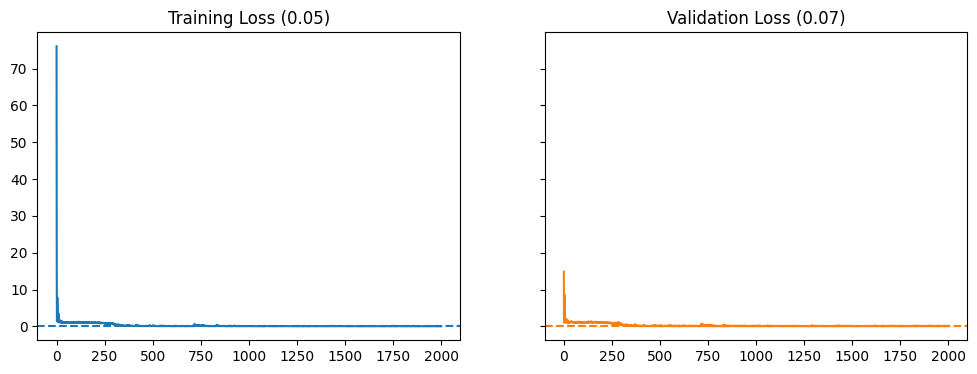

In [18]:
import matplotlib.pyplot as plt
import matplotlib

def plot_loss(steps, train_losses, valid_losses):
    fig, axs = plt.subplots(ncols=2, sharey=True, figsize=(12,4))
    axs[0].plot(steps, train_losses, label = "Training", color = 'C0')
    axs[0].axhline(y = np.mean(train_losses[-1000:]), color = 'C0', linestyle = '--')
    axs[0].set_title(f"Training Loss ({np.mean(train_losses[-1000:]):.2f})")
    axs[1].plot(steps, valid_losses, label = "Validation", color = '#ff7f0e')
    axs[1].axhline(y = np.mean(valid_losses[-1000:]), color = '#ff7f0e', linestyle = '--')
    axs[1].set_title(f"Validation Loss ({np.mean(valid_losses[-1000:]):.2f})")
    return axs
    
axs = plot_loss(steps, train_losses, valid_losses)

In [19]:
from sklearn.metrics import mean_squared_error, r2_score, mean_poisson_deviance, d2_tweedie_score
from xgboost import XGBRegressor

def evaluate(y_obs, preds, mode, model_name):
    report_dict = {}
    report_dict["rmse"] = np.sqrt(mean_squared_error(y_obs, preds))
    report_dict["r2"] = r2_score(y_obs, preds)
    report_dict["poisson_deviance"] = mean_poisson_deviance(y_obs, preds)
    report_dict["tweedie_score"] = d2_tweedie_score(y_obs, preds)
    report_dict["mode"] = mode
    report_dict["model"] = model_name
    return report_dict

def evaluate_nn(dataloader, model, mode):
    model.eval()
    
    y_obs = []
    preds = []

    with torch.no_grad():
        for xb_cat, xb_cont, yb in dataloader:
            logits = model(xb_cat, xb_cont)
            y_obs.append(yb.numpy())
            preds.append(logits.numpy())

    y_obs = np.concatenate(y_obs)
    preds = np.concatenate(preds)
    return y_obs, preds

def train_xgb(X_train, y_train, X_valid, y_valid):
    bst = XGBRegressor()
    
    bst.fit(X_train, y_train)
    preds_train = bst.predict(X_train)
    
    preds_valid = bst.predict(X_valid)
    return preds_train, preds_valid

def display_metrics(report_dicts):
    table = pd.concat([pd.DataFrame(rd, index=[i]) for i, rd in enumerate(report_dicts)])
    return table.set_index(["model", "mode"])

y_train_nn, nn_preds_train = evaluate_nn(train_dataloader, model, "Train")
y_valid_nn, nn_preds_valid = evaluate_nn(valid_dataloader, model, "Valid")

train_nn_report = evaluate(y_train_nn, nn_preds_train, "Train", model_name = "Transformer")
valid_nn_report = evaluate(y_valid_nn, nn_preds_valid, "Valid", model_name = "Transformer")

xgb_preds_train, xgb_preds_valid = train_xgb(X_train, y_train, X_valid, y_valid)
train_xgb_report = evaluate(y_train, xgb_preds_train, "Train", model_name = "XGBoost")
valid_xgb_report = evaluate(y_valid, xgb_preds_valid, "Valid", model_name = "XGBoost")

display_metrics([train_nn_report, valid_nn_report, train_xgb_report, valid_xgb_report])

rmse        r2  poisson_deviance  tweedie_score
model       mode                                                      
Transformer Train  0.288481  0.919153          0.010522       0.919153
            Valid  0.290436  0.918058          0.010687       0.918058
XGBoost     Train  0.076428  0.994325          0.000745       0.994325
            Valid  0.089086  0.992291          0.001020       0.992291

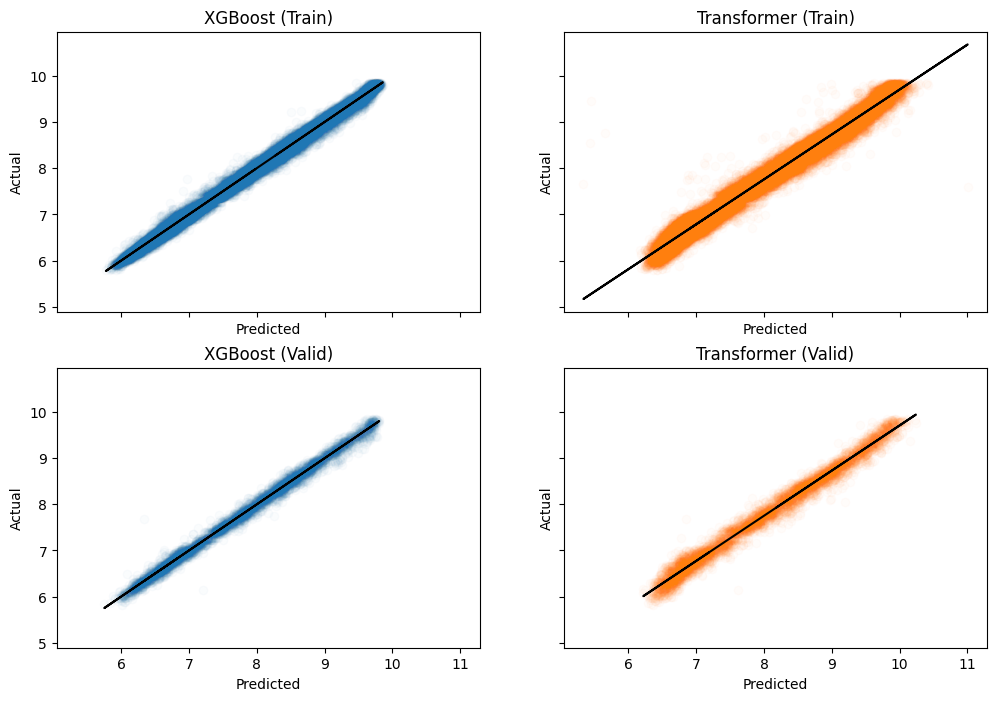

In [20]:
def plot_preds(ax, y_obs, preds, mode, color, model, alpha = 0.02):
    ax.scatter(preds, y_obs, color = color, alpha = alpha)
    z = np.polyfit(preds, y_obs, 1)
    p = np.poly1d(z)
    ax.plot(preds, p(preds), color = "k")
    ax.set_ylabel("Actual")
    ax.set_xlabel("Predicted")
    ax.set_title(f"{model} ({mode})")
    return ax

fig, axs = plt.subplots(ncols=2, nrows=2, sharey=True, sharex=True, figsize=(12,8))

axs[0,0] = plot_preds(axs[0,0], y_obs = y_train, preds = xgb_preds_train, mode="Train", model = "XGBoost", color = "tab:blue")
axs[0,1] = plot_preds(axs[0,1], y_obs = y_train_nn, preds = nn_preds_train, mode="Train", model = "Transformer", color = "tab:orange")

axs[1,0] = plot_preds(axs[1,0], y_obs = y_valid, preds = xgb_preds_valid, mode="Valid", model = "XGBoost", color = "tab:blue")
axs[1,1] = plot_preds(axs[1,1], y_obs = y_valid_nn, preds = nn_preds_valid, mode="Valid", model = "Transformer", color = "tab:orange")